In [6]:
!pip install pandas matplotlib librosa Pillow

# Hito 2: Análisis Exploratorio y Procesamiento de Datos
**Proyecto:** Detección de Anfibios (Deep Learning)
**Datos:** Dataset procesado (Spectrograms & Metadata)

## 1. Introducción
En este hito, analizamos la estructura del dataset ya procesado que servirá de entrada para la Red Neuronal Convolucional (CNN) en el Hito 3. Contamos con un conjunto de datos organizado por especies y un archivo de metadatos.

**Objetivos:**
1. Analizar el balance de clases (cantidad de muestras por especie).
2. Visualizar los espectrogramas generados (`tiny_specs`).
3. Validar el proceso de generación de características (Raw Audio -> Mel Spectrogram).

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from PIL import Image

# Configuración
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías cargadas.")

Librerías cargadas.


In [8]:

RUTA_METADATA = "C:/Users/svndo/ACUS220_Audio_DeepLearning/data/processed/tiny_specs/metadata.csv"

if os.path.exists(RUTA_METADATA):
    df = pd.read_csv(RUTA_METADATA)
    print("Metadata cargada exitosamente.")
    print(f"Total de muestras: {len(df)}")
    display(df.head()) # Muestra las primeras filas
else:
    print(f" No se encuentra el archivo en: {RUTA_METADATA}")
    print("Verifica la ruta relativa.")

Metadata cargada exitosamente.
Total de muestras: 1221


,wav,npz,label
0,data/raw/tiny_dataset/Batrachyla_leptopus/audi...,data/processed/tiny_specs/Batrachyla_leptopus/...,Batrachyla_leptopus
1,data/raw/tiny_dataset/Batrachyla_leptopus/audi...,data/processed/tiny_specs/Batrachyla_leptopus/...,Batrachyla_leptopus
2,data/raw/tiny_dataset/Batrachyla_leptopus/audi...,data/processed/tiny_specs/Batrachyla_leptopus/...,Batrachyla_leptopus
3,data/raw/tiny_dataset/Batrachyla_leptopus/audi...,data/processed/tiny_specs/Batrachyla_leptopus/...,Batrachyla_leptopus
4,data/raw/tiny_dataset/Batrachyla_leptopus/audi...,data/processed/tiny_specs/Batrachyla_leptopus/...,Batrachyla_leptopus


## 2. Distribución del Dataset
Es crucial saber si tenemos la misma cantidad de audios para cada especie. Un desbalance podría hacer que el modelo ignore a la especie con menos datos.

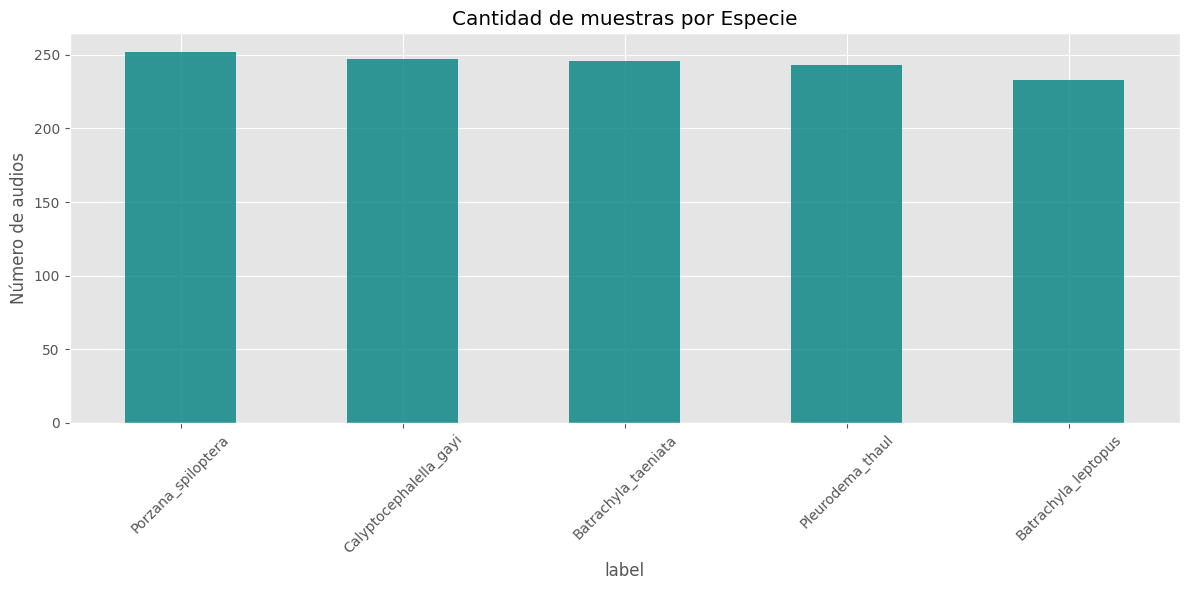

Detalle numérico:
label
Porzana_spiloptera        252
Calyptocephalella_gayi    247
Batrachyla_taeniata       246
Pleurodema_thaul          243
Batrachyla_leptopus       233
Name: count, dtype: int64


In [9]:
# Asumiendo que la columna de especies se llama 'Label', 'Species' o 'class_name'.
# Ajusta 'Label' por el nombre real de la columna en tu CSV.
columna_clase = 'label' # <--- VERIFICA ESTO EN EL OUTPUT ANTERIOR

if columna_clase in df.columns:
    conteo = df[columna_clase].value_counts()
    
    conteo.plot(kind='bar', color='teal', alpha=0.8)
    plt.title("Cantidad de muestras por Especie")
    plt.ylabel("Número de audios")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Detalle numérico:")
    print(conteo)
else:
    print(f"La columna '{columna_clase}' no existe en el CSV. Las columnas son: {df.columns}")

## 3. Visualización de los Inputs de la Red (Tiny Specs)
El modelo no "escuchará" audio, sino que "verá" imágenes. Estas son las muestras que ya tenemos procesadas en la carpeta `tiny_specs`.b

 Buscando en: C:\Users\svndo\ACUS220_Audio_DeepLearning\data\processed\tiny_specs\Pleurodema_thaul
 Archivos .npz encontrados: 243
 Contenido del archivo (keys): ['stft_db', 'mel_db', 'mfcc', 'gammatone_db', 'meta']
 Dimensiones de la matriz: (513, 173)


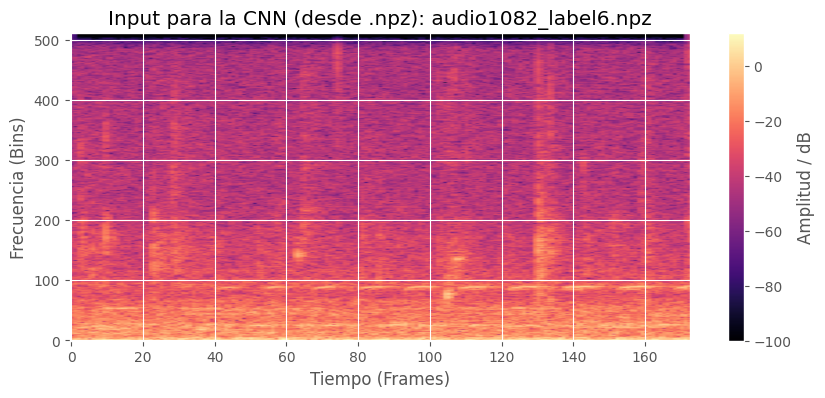

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt

# --- RUTA ABSOLUTA ---
directorio_especie = r"C:\Users\svndo\ACUS220_Audio_DeepLearning\data\processed\tiny_specs\Pleurodema_thaul"

print(f" Buscando en: {directorio_especie}")

if os.path.exists(directorio_especie):
    # 1. Buscamos archivos .npz en lugar de .png
    archivos = [f for f in os.listdir(directorio_especie) if f.endswith('.npz')]
    print(f" Archivos .npz encontrados: {len(archivos)}")

    if len(archivos) > 0:
        # Tomamos el primero de la lista para probar
        archivo_prueba = archivos[0]
        ruta_completa = os.path.join(directorio_especie, archivo_prueba)
        
        # 2. Cargamos el archivo con NumPy
        datos = np.load(ruta_completa)
        
        # Un .npz es como un diccionario, veamos qué 'llaves' tiene dentro
        print(f" Contenido del archivo (keys): {datos.files}")
        
        # Extraemos la matriz (generalmente la primera llave guarda el espectrograma)
        # Si tus llaves dicen 'arr_0', usaremos esa.
        nombre_llave = datos.files[0]
        espectrograma = datos[nombre_llave]
        
        print(f" Dimensiones de la matriz: {espectrograma.shape}")
        
        # 3. Visualizamos la matriz como imagen
        plt.figure(figsize=(10, 4))
        plt.imshow(espectrograma, origin='lower', aspect='auto', cmap='magma')
        plt.colorbar(label='Amplitud / dB')
        plt.title(f"Input para la CNN (desde .npz): {archivo_prueba}")
        plt.xlabel("Tiempo (Frames)")
        plt.ylabel("Frecuencia (Bins)")
        plt.show()
        
    else:
        print(" La carpeta existe pero no hay archivos .npz dentro.")
else:
    print(" Error de ruta.")

## 4. Validación del Procesamiento (Audio a Espectrograma)
Aunque ya tenemos las imágenes, como ingenieros debemos validar el proceso físico-matemático. A continuación, cargamos un audio crudo (`.wav`) y replicamos manualmente el proceso para verificar que la conversión a Escala Mel es correcta.

La transformación utiliza la escala Mel para imitar la audición biológica:
$$m = 2595 \cdot \log_{10}(1 + \frac{f}{700})$$

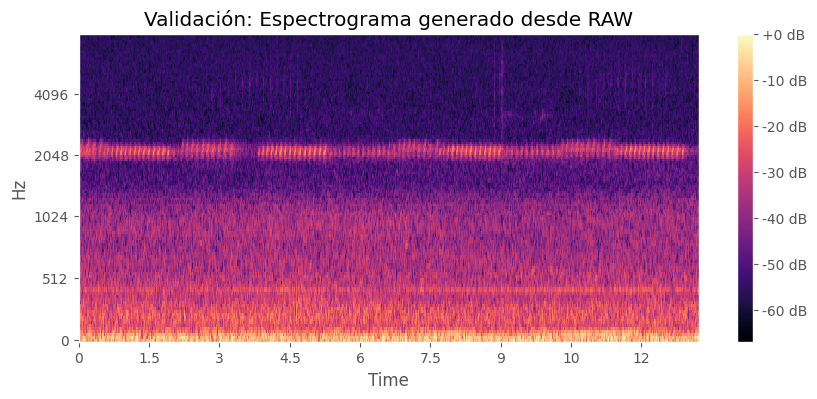

In [11]:
# Aquí usas el código que te di antes para cargar UN audio .wav original
# (Asegúrate de tener un .wav en raw/ para probar esto)

ruta_wav = r"C:\Users\svndo\Downloads\raw\raw\tiny_dataset\Pleurodema_thaul\audio198_label11.wav" # <--- Pon un wav real aquí

if os.path.exists(ruta_wav):
    y, sr = librosa.load(ruta_wav, sr=None)
    
    # Generar Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title("Validación: Espectrograma generado desde RAW")
    plt.show()
else:
    print(" Para esta sección necesitas tener el archivo .wav original.")